In [349]:
from statsmodels.tsa.seasonal import STL
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.graphics.tsaplots import plot_pacf, plot_acf
from pmdarima.arima.utils import ndiffs
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import datetime
import pmdarima as pm

%matplotlib inline

Data preprocessing.

In [350]:
cod_ccaa_cell = {'AN': 'Andalucía',
                 'AR': 'Aragón',
                 'AS': 'Principado de Asturias',
                 'IB': 'Islas Baleares',
                 'CN': 'Canarias',
                 'CB': 'Cantabria',
                 'CM': 'Castilla-La Mancha',
                 'CL': 'Castilla y León',
                 'CT': 'Cataluña',
                 'CE': 'Ceuta',
                 'VC': 'Comunidad Valenciana',
                 'EX': 'Extremadura',
                 'GA': 'Galicia',
                 'MD': 'Comunidad de Madrid',
                 # 'ME': 'Melilla',
                 'MC': 'Región de Murcia',
                 'NC': 'Comunidad Foral de Navarra',
                 'PV': 'País Vasco',
                 'RI': 'La Rioja'}

def data_loading():
    # results_url = "https://covid19.isciii.es/resources/serie_historica_acumulados.csv"
    results_url = "../data/serie_historica_acumulados.csv"

    df = pd.read_csv(results_url, engine='python')
    df = df.fillna(0)

    df = df[df['CCAA'].isin(cod_ccaa_cell.keys())]

    df['FECHA'] = pd.to_datetime(df['FECHA'], format="%d/%m/%Y")

    df = df.set_index('FECHA')

    df['CASOS'] = df['CASOS'] + df['PCR+']
    df = df.drop(columns=['PCR+', 'TestAc+'])
    return df

df = data_loading()
df = df[df['CCAA'] == 'MD']
for feature_daily in ['CASOS', 'Recuperados', 'Fallecidos']:
     df[feature_daily] = df[feature_daily].diff().fillna(0)

end_date_training = datetime.date(2020,4,30)
end_date_testing = datetime.date(2020,5,7)

Decomposition of seasonability and trend.

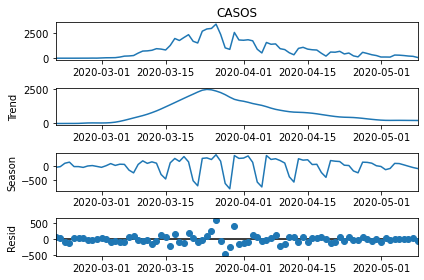

In [351]:
decomp = STL(df['CASOS'], period=7).fit()
decomp.plot()
plt.show()

ADF test to make series stationary.

No differenciation.

In [352]:
from statsmodels.tsa.stattools import adfuller
result = adfuller(df['CASOS'])
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1]) #p-value: 0.159373

ADF Statistic: -2.456233
p-value: 0.126490


Number of differenciations needed.

In [353]:
d = ndiffs(df['CASOS'], test='adf')

Finding the p value with partial-autocorrelation.

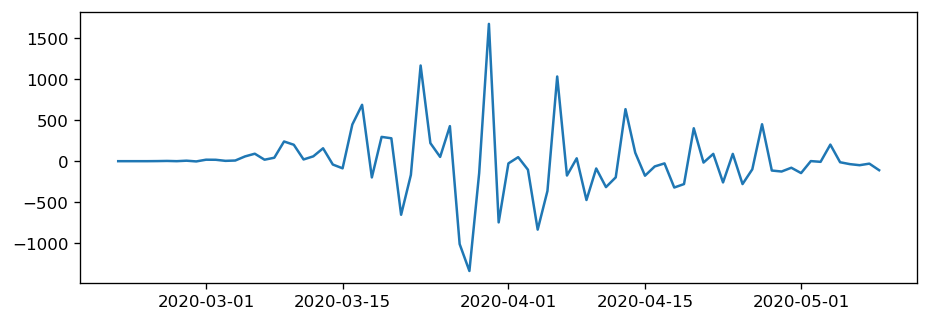

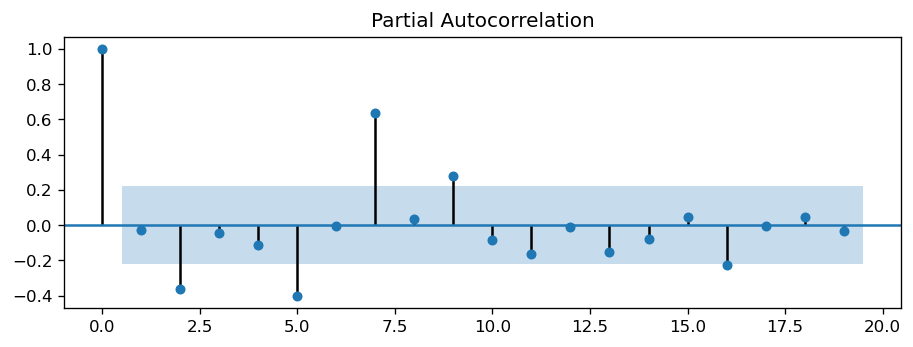

In [354]:
plt.rcParams.update({'figure.figsize':(9,3), 'figure.dpi':120})

plt.plot(df['CASOS'].diff())
plot_pacf(df['CASOS'].diff().dropna())

plt.show()

p = 1

Finding the p value with autocorrelation.

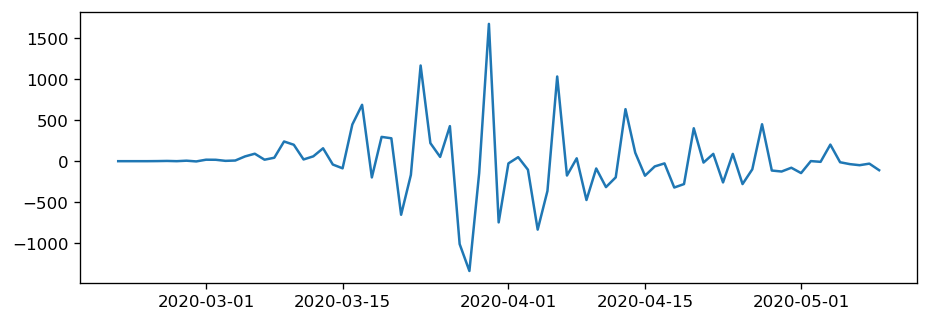

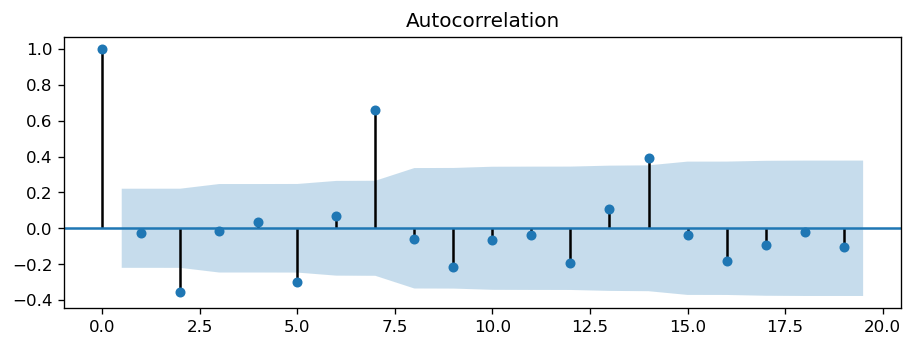

In [355]:
plt.rcParams.update({'figure.figsize':(9,3), 'figure.dpi':120})

plt.plot(df['CASOS'].diff())
plot_acf(df['CASOS'].diff().dropna())

plt.show()

q = 1

ARIMA forecasting with the terms previously found.

c:\users\usuario\pycharmprojects\coronavirus2020\env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
c:\users\usuario\pycharmprojects\coronavirus2020\env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


                             ARIMA Model Results                              
Dep. Variable:                D.CASOS   No. Observations:                   70
Model:                 ARIMA(1, 1, 1)   Log Likelihood                -521.107
Method:                       css-mle   S.D. of innovations            413.468
Date:                Mon, 11 May 2020   AIC                           1050.215
Time:                        09:35:43   BIC                           1059.209
Sample:                    02-21-2020   HQIC                          1053.787
                         - 04-30-2020                                         
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const             4.8073     28.647      0.168      0.867     -51.340      60.955
ar.L1.D.CASOS     0.4869      0.194      2.512      0.012       0.107       0.867
ma.L1.D.CASOS    -0.7090      0.141     

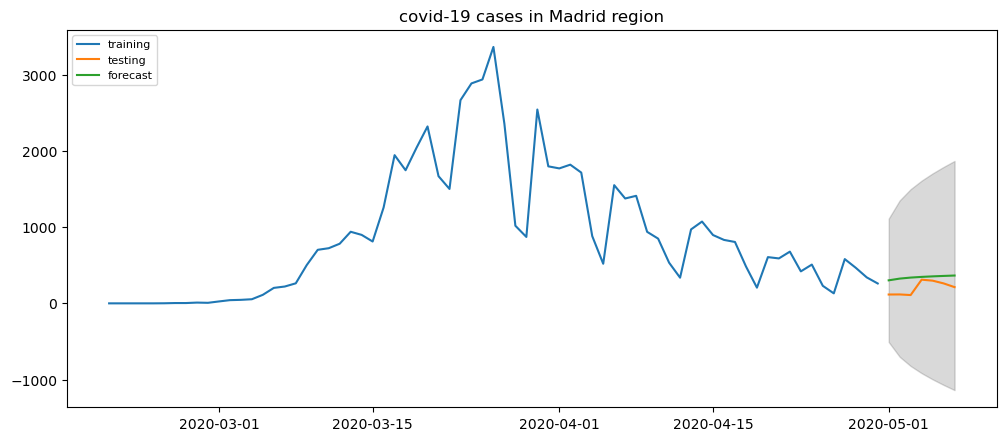

In [356]:
df_testing = df[(end_date_training + datetime.timedelta(days=1)):end_date_testing]
df_training = df[:end_date_training]
model = ARIMA(df_training['CASOS'], order=(p,d,q))
model_fit = model.fit(disp=0)
print(model_fit.summary())

fc, se, conf = model_fit.forecast(7, alpha=0.05)  # 95% conf

# Make as pandas series
fc_series = pd.Series(fc, index=df_testing.index)
lower_series = pd.Series(conf[:, 0], index=df_testing.index)
upper_series = pd.Series(conf[:, 1], index=df_testing.index)

# Plot
plt.figure(figsize=(12,5), dpi=100)
plt.plot(df_training['CASOS'], label='training')
plt.plot(df_testing['CASOS'], label='testing')
plt.plot(fc_series, label='forecast')
plt.fill_between(lower_series.index, lower_series, upper_series,
                 color='k', alpha=.15)
plt.title('covid-19 cases in Madrid region')
plt.legend(loc='upper left', fontsize=8)
plt.show()

Mape for the forecast.

In [357]:
series_error = (np.abs(df_testing['CASOS'] - fc_series))
np.mean(series_error/df_testing['CASOS']) # MAPE

0.9832792923122585

Autoarima forecast.

Performing stepwise search to minimize aic
Fit ARIMA(1,1,1)x(0,0,0,0) [intercept=True]; AIC=943.607, BIC=952.601, Time=0.099 seconds
Fit ARIMA(0,1,0)x(0,0,0,0) [intercept=True]; AIC=946.849, BIC=951.346, Time=0.007 seconds
Fit ARIMA(1,1,0)x(0,0,0,0) [intercept=True]; AIC=948.842, BIC=955.587, Time=0.029 seconds
Fit ARIMA(0,1,1)x(0,0,0,0) [intercept=True]; AIC=948.795, BIC=955.541, Time=0.038 seconds
Fit ARIMA(0,1,0)x(0,0,0,0) [intercept=False]; AIC=944.918, BIC=947.166, Time=0.006 seconds
Fit ARIMA(2,1,1)x(0,0,0,0) [intercept=True]; AIC=935.396, BIC=946.638, Time=0.083 seconds
Fit ARIMA(2,1,0)x(0,0,0,0) [intercept=True]; AIC=936.778, BIC=945.772, Time=0.059 seconds
Fit ARIMA(3,1,1)x(0,0,0,0) [intercept=True]; AIC=937.392, BIC=950.883, Time=0.181 seconds
Fit ARIMA(2,1,2)x(0,0,0,0) [intercept=True]; AIC=937.151, BIC=950.642, Time=0.198 seconds
Fit ARIMA(1,1,2)x(0,0,0,0) [intercept=True]; AIC=936.447, BIC=947.689, Time=0.131 seconds
Fit ARIMA(3,1,0)x(0,0,0,0) [intercept=True]; AIC=937.078

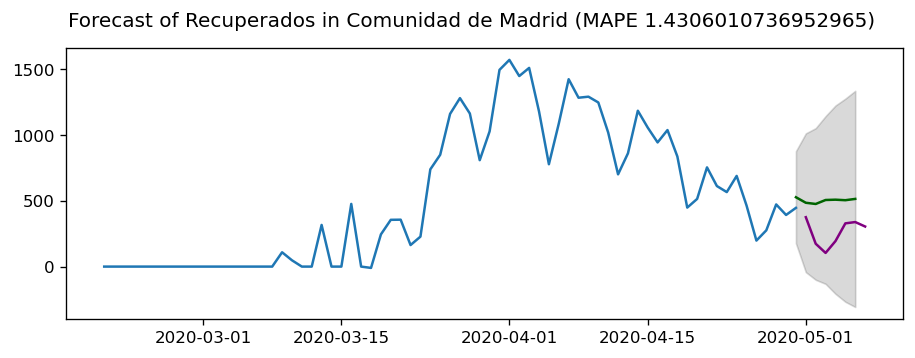

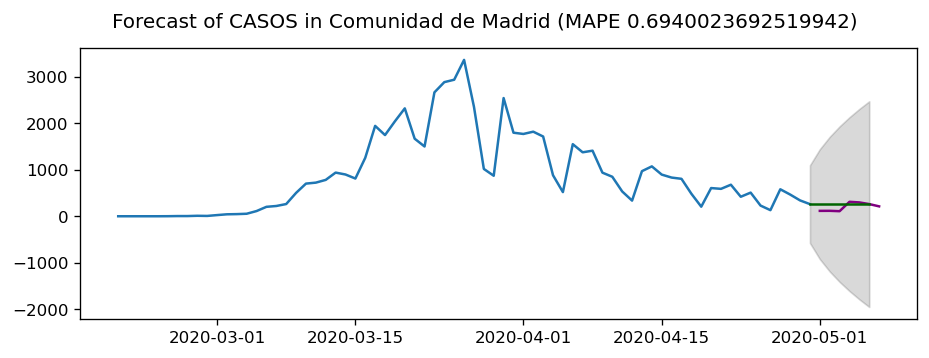

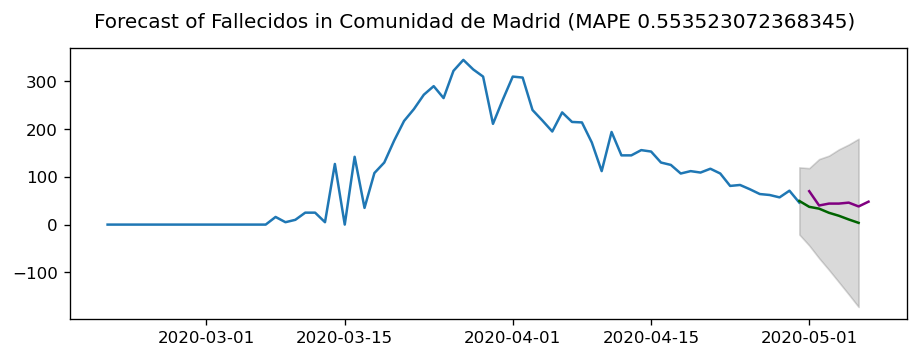

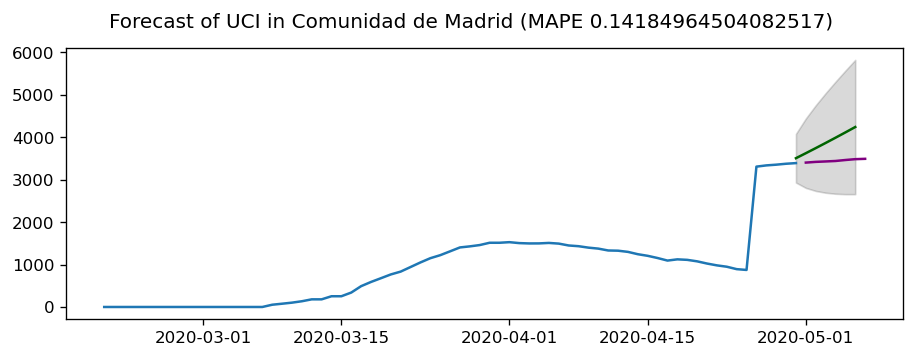

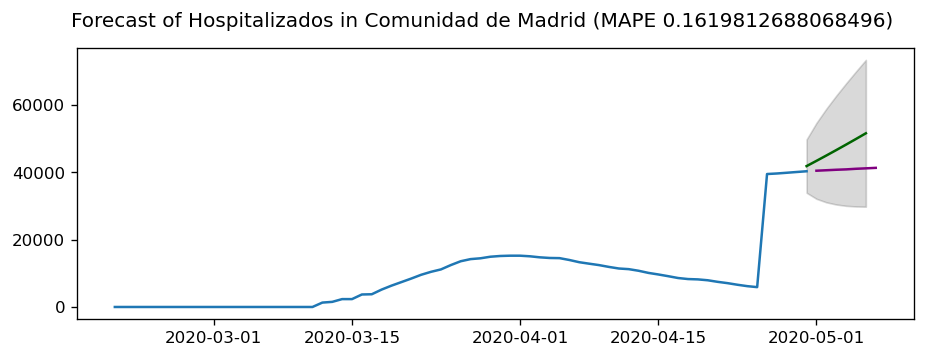

In [358]:
n_periods = 7
df_ca_result = pd.DataFrame(columns=["CCAA", "FECHA", 'Recuperados', 'CASOS', 'Fallecidos', 'UCI', 'Hospitalizados'])
for feature in ['Recuperados', 'CASOS', 'Fallecidos', 'UCI', 'Hospitalizados']:
    model = pm.auto_arima(df_training[feature],
                          start_p=1, start_q=1,
                          test='adf',       # use adftest to find optimal 'd'
                          max_p=3, max_q=3, # maximum p and q
                          m=1,              # frequency of series
                          d=None,           # let model determine 'd'
                          seasonal=False,   # No Seasonality
                          start_P=0,
                          D=0,
                          trace=True,
                          error_action='ignore',
                          suppress_warnings=True,
                          stepwise=True)
    #print(model.summary())
    #model.plot_diagnostics(figsize=(7,5))
    #plt.show()
    # Forecast
    fc, confint = model.predict(n_periods=n_periods, return_conf_int=True)
    index_of_fc = [end_date_training + datetime.timedelta(days=x) for x in range(n_periods)]
    # make series for plotting purpose
    fc_series = pd.Series(fc, index=index_of_fc)
    df_ca_result[feature] = fc_series
    lower_series = pd.Series(confint[:, 0], index=index_of_fc)
    upper_series = pd.Series(confint[:, 1], index=index_of_fc)

    mape = np.mean(np.abs(fc_series - df_testing[feature])/np.abs(df_testing[feature]))  # MAPE

    # Plot
    fig = plt.figure()
    fig.suptitle("Forecast of {0} in {1} (MAPE {2})"
                                              .format(feature, cod_ccaa_cell['MD'], mape))
    plt.plot(df_training[feature])
    plt.plot(df_testing[feature], color='purple')
    plt.plot(fc_series, color='darkgreen')
    plt.fill_between(lower_series.index,
                     lower_series,
                     upper_series,
                     color='k', alpha=.15)
    plt.show()
